In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
store = pd.read_csv('./drive/MyDrive/store.csv')
train = pd.read_csv('./drive/MyDrive/train.csv')
merged = train.merge(store, on='Store',how='inner')
merged['Date'] = pd.to_datetime(merged['Date'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Preprocessing**


> Our preprocessing includes 
  *   resolving nulls
  *   removing duplicates
  *   changing to correct data types
  *   encoding categorical data




In [ ]:
# We check the number of nulls and duplicates
print(f'Nulls:\n{merged.isna().sum()}')
print(f'\nDuplicates: {merged.duplicated().sum()}')

Nulls:
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2366
CompetitionOpenSinceMonth    290780
CompetitionOpenSinceYear     290780
Promo2                            0
Promo2SinceWeek              457983
Promo2SinceYear              457983
PromoInterval                457983
dtype: int64

Duplicates: 0






**No duplicates.**

We have null values on **CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, PromoInterval**. We take a look at these columns to explain these nulls and derive proper values for them, or to drop them.

1. Promo2SinceWeek/Year and Interval have the same number of nulls. Upon checking, this shows that these rows are null because they *do not have a promo2* at all.
 * To resolve this, we simply set the null values in these columns as 0


2. CompetitionOpenSinceMonth/Year have the same number of nulls but some overlap with the nulls of CompetitionDistance. This suggests that rows which have nulls on these 3 columns *do not have any competition*.
 * To resolve this, we get the rows that have nulls on CompetitionDistance and CompetitionOpenSinceMonth/Year. 
 * We then set these to 0 


3. The remaining nulls on CompetitionOpenSinceMonth/Year have values on CompetitionDistance which suggests that competition exists, but there is no stored data on when they are open.
  * To resolve this, we assume that the date of the transaction is the earliest instance of the competition being open.
  * We get the month and year of the transaction date of that row and use this to fill the null columns.
  





In [ ]:
#Getting the index of rows with no PromoInterval for preprocessing scenario 1
no_promos = merged[merged['PromoInterval'].isna()==True].index
#Setting the null values based on index to zero
merged.loc[no_promos,('PromoInterval','Promo2SinceYear','Promo2SinceWeek')] = merged.loc[no_promos,('PromoInterval','Promo2SinceYear','Promo2SinceWeek')].fillna(0)


#Getting the index of rows with no CompetitionDistance and CompetitionOpenSinceYear for preprocessing scenario 2
no_comp = merged[ (merged['CompetitionDistance'].isna()==True) & (merged['CompetitionOpenSinceYear'].isna()==True)].index
#Setting the null values based on index to zero
merged.loc[no_comp,('CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear')] = merged.loc[no_comp,('CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear')].fillna(0)

#Getting a subsect of the data which have null valyes for CompetitionOpenSinceYear
no_date = merged[merged['CompetitionOpenSinceYear'].isna()==True]
#Using this subsect, set the null values of CompetitionOpenSinceMonth/Year with the year and month of the Date column
no_date['CompetitionOpenSinceYear'] =  no_date['Date'].dt.year
no_date['CompetitionOpenSinceMonth'] =  no_date['Date'].dt.month
#Merging this subsect with the original data, combination is based on the index
merged = merged.combine_first(no_date)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
# We check again the number of nulls and duplicates
print(f'Nulls:\n{merged.isna().sum()}')
print(f'\nDuplicates: {merged.duplicated().sum()}')

Nulls:
Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Duplicates: 0


In [ ]:
#We then check if the data types are correct
merged.info()
print('\n\nWe can see that StateHoliday, StoreType, and Assortment are objects. \nIn the project brief, we can see these are categorical data that were encoded as abcd. \nGiven this, we can just replace this mapping with numerical representation.')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914629 entries, 0 to 914628
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      914629 non-null  int64         
 1   DayOfWeek                  914629 non-null  int64         
 2   Date                       914629 non-null  datetime64[ns]
 3   Sales                      914629 non-null  int64         
 4   Customers                  914629 non-null  int64         
 5   Open                       914629 non-null  int64         
 6   Promo                      914629 non-null  int64         
 7   StateHoliday               914629 non-null  int64         
 8   SchoolHoliday              914629 non-null  int64         
 9   StoreType                  914629 non-null  int64         
 10  Assortment                 914629 non-null  int64         
 11  CompetitionDistance        914629 non-null  float64 

In [ ]:
merged['StateHoliday'].replace({'a':1,'b':2,'c':3,'0':0}, inplace=True)
merged['StoreType'].replace({'a':1,'b':2,'c':3,'d':4}, inplace=True)
merged['Assortment'].replace({'a':1,'b':2,'c':3}, inplace=True)

# **EDA**


> Now that our data has been processed, we explore and find any relationships or correlations. Our EDA includes:
* Investigating the target variable (sales)
* Evaluate the target variable against the other features
* Check the correlations





/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


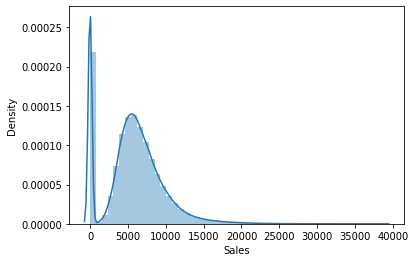

Target Skew:  0.6542283225449831
Target Kurtosis:  1.8050559524768128


In [ ]:
#Review the target variable's distribution, shape
sns.distplot(merged['Sales'])
plt.show()
print('Target Skew: ',merged['Sales'].skew())
print('Target Kurtosis: ',merged['Sales'].kurt())

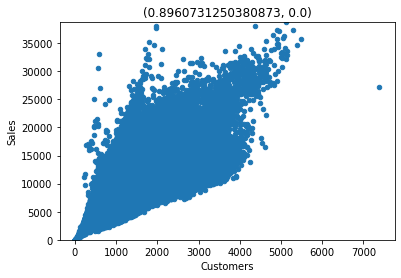

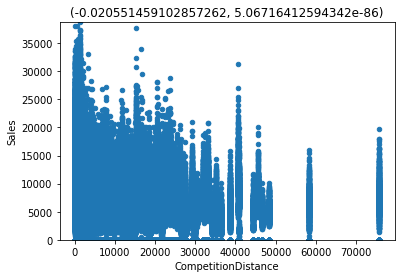

In [ ]:
quan = ['Customers','CompetitionDistance']
for var in quan:
  merged.plot.scatter(x=var, y='Sales', ylim=(0,merged['Sales'].max()))
  plt.title(stats.pearsonr(merged['Sales'], merged[var])) #Returns your r-alue and p-value. Use it for correlation.


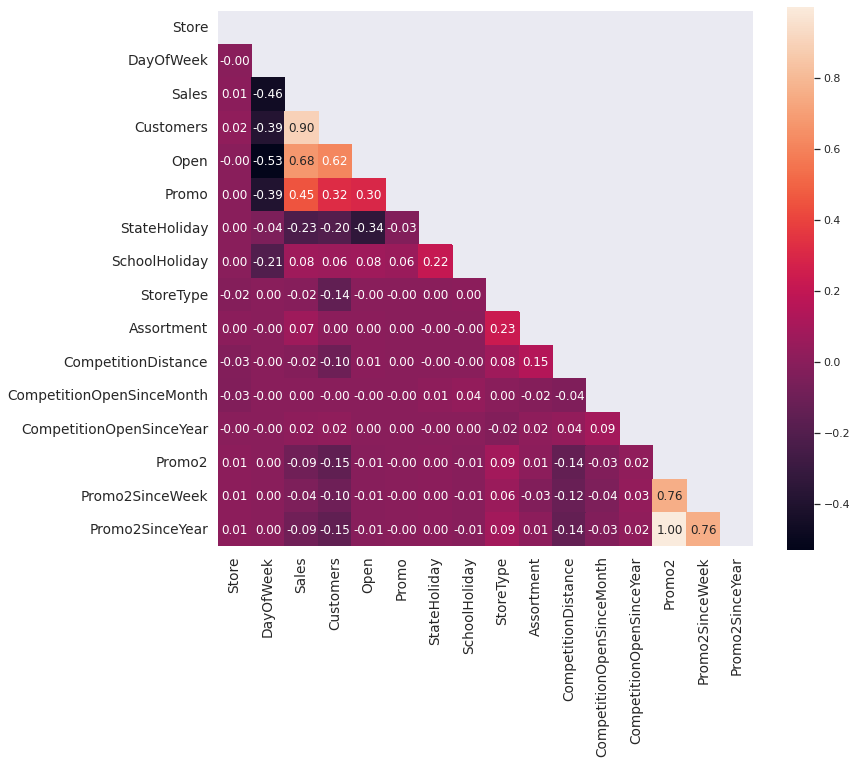

In [ ]:
#Create a heatmap of all variables 
fig, ax = plt.subplots(figsize=(12, 10))
corrmat = merged.corr()
cols =corrmat.index
cm = np.corrcoef(merged[cols].values.T)
mask = np.triu(np.ones_like(cm, dtype=np.bool))
sns.set(font_scale=1)

hm = sns.heatmap(cm, cbar=True, square=True, mask=mask, annot=True, fmt='.2f',
                yticklabels=cols.values, xticklabels=cols.values)

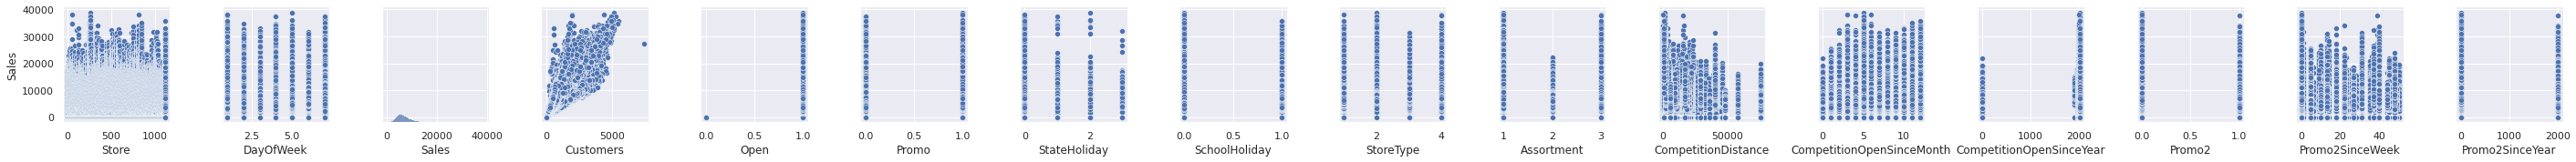

In [ ]:
sns.pairplot(merged[cols], y_vars='Sales')

# **Feature Engineering**


> Given the EDA, we may want to generate a feature that captures the relationship between customers and sales. Additionally, we may want to better represent the PromoInterval column.


1.   For the PromoInterval, it contains the months that the promo2 runs. We can represent this as the **PromoStart** Month, **PromoEnd** Month, and **PromoDuration** in Months.
2.   For the customer and sales, we simply divide the sales per customer on that day. This gives us the **Avg Sale per Customer** feature.






In [ ]:
#Split the PromoInterval to get the first and last month 
interval = merged['PromoInterval'].str.split(',',1,expand=True).rename({0:'start',1:'rep'},axis=1)
interval[['rep','end']] = interval['rep'].str.rsplit(',',1,expand=True)
merged[['PromoStart','PromoEnd']] = interval[['start','end']]
#Count how many commas are in between each month of PromoInterval and add 1 to get how many months the promo runs for
merged['PromoDuration'] = merged['PromoInterval'].str.count(',')+1


#Get a subsect of the data with non-null values under PromoStart/End
with_promo = merged[merged['PromoStart'].isna()==False]
#In the subsect, replace the PromoStart/End month as its numerical representation
with_promo['PromoEnd'] = with_promo['PromoEnd'].apply(lambda x: pd.datetime.strptime(x,'%b').month)
with_promo['PromoStart'] = with_promo['PromoStart'].apply(lambda x: pd.datetime.strptime(x,'%b').month)

#Combine the 2 dataframes to replace the values, then remove the PromoInterval column
merged = with_promo.combine_first(merged)
merged.drop(columns='PromoInterval',inplace=True)

#Get the average sales per customer
merged['Avg SalesCust'] = merged['Sales'] / merged['Customers']
#For any nulls generated (no sales and customers will result in null, no PromoInterval also results in nulls), we simply fill as 0
merged = merged.fillna(0)

#Encode the date as its ordinal representation to be accepted by models/scalers
merged['Date'] = merged['Date'].apply(lambda x: x.toordinal())

457983


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [ ]:
#Now we can separate the input data from our target
data = merged.drop(columns='Sales')
target = merged[['Sales']]

# **Feature Reduction**



> We have 20 features now. We may want to identify which features contribute the most to our model. Using Feature Reduction/Transformation methods can help with this. In this use-case we will use PCA. Here are the steps:


1. Scale our data using standard scaler
2. Fit transform the scaled data
3. Get the explained variance, exp. variance ratio, and the cumulative sum of the exp. var. ratio
4. Get the principal components that are less than the cumsum exp. var. ratio threshold
5. Use the number of retained principal components, we run another PCA
6. From the resulting PCA, we get the most important feature name of each principal component
7. We then use these feature names as our final input data  





In [ ]:
#1st round of PCA with our scaled data
pca = PCA(random_state=42)
X = StandardScaler().fit_transform(data)

pca.fit_transform(X)
#Create a dataframe that contains explained variance, exp. var. ratio, and cumulative sum of exp. var. ratio
pca_df = pd.DataFrame(pca.explained_variance_, columns = ['explained_variance'])
pca_df['explained_variance_ratio'] = pca.explained_variance_ratio_
pca_df['cumsum_explained_variance_ratio'] = pca_df['explained_variance_ratio'].cumsum()

#Get the principal components that are below our threshold
pca_df_reduced =  pca_df[pca_df['cumsum_explained_variance_ratio'] <= 0.995]
#Get the number of components to keep
components_to_keep = pca_df_reduced.shape[0]

#2nd round of PCA with the identified number of components 
pca = PCA(n_components=components_to_keep)
print(f"No. of reduced features using PCA : {20 - components_to_keep}")
pca.fit_transform(X)

#Create a data frame that shows which feature was the most important for each principal component
n_pcs = pca.components_.shape[0]
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = data.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

#Use these features to create our final input data
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(dic.items())
inputs = data[df[1].unique()]

No. of reduced features using PCA : 5


In [ ]:
#Finally we split our data to run our models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.3, random_state=42)

# **Modelling**


> Since we want to predict Sales price, we will try to use linear regression models. We are comparing 5 models **(linear regression, ridgeCV, LarsCV, LassoCV, and Catboost)**. 
>
> We will then evaluate performance using **Root Mean Squared Error (RMSE) **and **R-squared (R2 Score)** as our main metrics.



In [ ]:
from sklearn.linear_model import LinearRegression, LarsCV, RidgeCV, LassoCV
!pip install catboost
import catboost as cat

lr = LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)

ridge = RidgeCV(cv=5,gcv_mode='svd').fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

lars = LarsCV().fit(X_train, y_train)
lars_pred = lars.predict(X_test)

lasso = LassoCV(random_state=42).fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

cats = cat.CatBoostRegressor(random_state=42,verbose=0).fit(X_train, y_train)
cats_pred = cats.predict(X_test)

     |████████████████████████████████| 76.3 MB 66 kB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

print(f'Linear Regression - R2 Score: {r2_score(y_test,lr_pred)}, RMSE Score: {np.sqrt(mean_squared_error(y_test,lr_pred))}')
print(f'Ridge CV - R2 Score: {r2_score(y_test,ridge_pred)}, RMSE Score: {np.sqrt(mean_squared_error(y_test,ridge_pred))}')
print(f'Lars CV - ER2 Score: {r2_score(y_test,lars_pred)}, RMSE Score: {np.sqrt(mean_squared_error(y_test,lars_pred))}')
print(f'Lasso CV - R2 Score: {r2_score(y_test,lasso_pred)}, RMSE Score: {np.sqrt(mean_squared_error(y_test,lasso_pred))}')
print(f'CatBoost - R2 Score: {r2_score(y_test,cats_pred)}, RMSE Score: {np.sqrt(mean_squared_error(y_test,cats_pred))}')

Linear Regression - R2 Score: 0.8684209414148553, RMSE Score: 1392.9937905850702
Ridge CV - R2 Score: 0.8684209394040319, RMSE Score: 1392.9938012291066
Lars CV - ER2 Score: 0.8684209414148559, RMSE Score: 1392.993790585067
Lasso CV - R2 Score: 0.8109068622796887, RMSE Score: 1669.91235273533
CatBoost - R2 Score: 0.9816738221760539, RMSE Score: 519.866390726489


4 out of 5 of our models are able to explain over 85% of the data (given R2 Score) and our RMSE scores are relatively low. 

We will choose **Catboost** since it gives the **hightes R2 score** and **lowest RMSE score**.

# **Saving to joblib file**


> Our next step is to save the trained model and create a single function for the data preprocessing we performed.



In [ ]:
def preprocess(df):
  df['Date'] = pd.to_datetime(df['Date'])
  interval = df['PromoInterval'].str.split(',',1,expand=True).rename({0:'start',1:'rep'},axis=1)
  interval[['rep','end']] = interval['rep'].str.rsplit(',',1,expand=True)
  df[['PromoStart','PromoEnd']] = interval[['start','end']]
  df['PromoDuration'] = df['PromoInterval'].str.count(',')

  with_promo = merged[merged['PromoStart'].isna()==False]
  with_promo['PromoEnd'] = with_promo['PromoEnd'].apply(lambda x: pd.datetime.strptime(x,'%b').month)
  with_promo['PromoStart'] = with_promo['PromoStart'].apply(lambda x: pd.datetime.strptime(x,'%b').month)
  df = with_promo.combine_first(df)
  df['Avg SalesCust'] = df['Sales'] / df['Customers']
  df = df.fillna(0)

  df.drop(columns='PromoInterval',inplace=True)
  df['Date'] = df['Date'].apply(lambda x: x.toordinal())
  data = merged.drop(columns='Sales')
  pca = PCA(random_state=42)
  X = StandardScaler().fit_transform(data)

  pca_output = pca.fit_transform(X)
  pca_df = pd.DataFrame(pca.explained_variance_, columns = ['explained_variance'])
  pca_df['explained_variance_ratio'] = pca.explained_variance_ratio_
  pca_df.reset_index(inplace=True)
  pca_df['cumsum_explained_variance_ratio'] = pca_df['explained_variance_ratio'].cumsum()
  pca_df_reduced =  pca_df[pca_df['cumsum_explained_variance_ratio'] <= 0.995]
  components_to_keep = pca_df_reduced.shape[0]
  pca = PCA(n_components=components_to_keep)
  reduced_df = pca.fit_transform(X)
  inputs = pd.DataFrame(reduced_df)
  return inputs

In [ ]:
import joblib

joblib.dump(cats, 'pred_model2.joblib') 
joblib.dump(preprocess, 'preprocess.joblib') 

['preprocess.joblib']